# Transfermarkt Transfers

**Disclaimers** : 
- The analysis scope is based on the dataset, especially on the defined transfer date range. Some info and numbers may differ from the real complete data out there.
- Some data may be missing because of scraping issue or restricted by the transfermarkt themselves. These could causing an innacurate conclusions.

The dataset was politely scraped from [transfermarkt.com](https://www.transfermarkt.com/statistik/transfertage) using Scrapy and Splash. The notebook will be updated as the scraping goes from time to time. Check the `Transfer Date Range` section below to find out the oldest and latest date.

## Preparation

### Import Libraries

In [253]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import sys
import datetime
import numpy as np
from IPython.core.interactiveshell import InteractiveShell

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

print("python version: ", sys.version)
print("pandas version: ", pd.__version__)
print("seaborn version: ", sns.__version__)

print("last run: ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

python version:  3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
pandas version:  1.3.4
seaborn version:  0.11.2
last run:  2022-02-08 04:52:51


### Loading Dataset

In [254]:
df = pd.read_csv("transfermarkt-transfers.csv")
dataset = df.copy()

# developer-friendly column names and format
dataset.columns = [x.lower().replace('-', '_').replace(' ', '_') for x in dataset.columns.to_list()]

### Variables and Functions

In [255]:
binary_pallete = ['#EF4444', '#10B981']
binary_order = ['No', 'Yes']

def remove_outlier_iqr(dataset, col):
    filtered_entries = np.array([True] * len(dataset))
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((dataset[col] >= low_limit) & (dataset[col] <= high_limit)) & filtered_entries

    dataset = dataset[filtered_entries]
    return dataset

## Dataset Exploration

In [256]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89405 entries, 0 to 89404
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            88352 non-null  float64
 1   name                 89405 non-null  object 
 2   age                  88937 non-null  float64
 3   position             89405 non-null  object 
 4   national_1           75344 non-null  object 
 5   national_2           11496 non-null  object 
 6   left_club            88449 non-null  object 
 7   left_club_league     64869 non-null  object 
 8   joined_club          87812 non-null  object 
 9   joined_club_league   60878 non-null  object 
 10  transfer_date        89405 non-null  object 
 11  transfer_date_p      89405 non-null  object 
 12  market_value         89405 non-null  object 
 13  market_value_p       89405 non-null  int64  
 14  fee                  89401 non-null  object 
 15  left_club_country    82226 non-null 

- The dataset has `23 columns` and `89404 rows` (the number will keep increasing)
- The default features mostly are object or categorical, but has a few numerical features too.

In [257]:
dataset.sample(10, random_state=1)

,player_id,name,age,position,national_1,national_2,left_club,left_club_league,joined_club,joined_club_league,transfer_date,transfer_date_p,market_value,market_value_p,fee,left_club_country,joined_club_country,loan_fee,loan_fee_p,created_at,updated_at,temp_dates_page,temp_players_page
8414,394304.0,Manolo Portanova,20.0,Attacking Midfield,Italy,NaN,Juventus U23,Serie C - A,Juventus,Serie A,"Oct 1, 2020",2020-10-01,€600Th.,600000,-,Italy,Italy,NaN,NaN,2021-10-04 16:24:18,2021-10-04 16:24:18,NaN,NaN
16712,183499.0,Shkodran Maholli,27.0,Centre-Forward,Sweden,Kosovo,Silkeborg IF,1.Division,Helsingborg,Allsvenskan,"Aug 25, 2020",2020-08-25,€200Th.,200000,free transfer,Denmark,Sweden,NaN,NaN,2021-10-04 17:02:02,2021-10-04 17:02:02,NaN,NaN
52724,247921.0,Rafa de Vicente,27.0,Central Midfield,NaN,NaN,UCAM Murcia,Primera Div. R.F.E.F. - Gr. II,Dep. La Coruña,Primera Div. R.F.E.F. - Gr. I,"Jul 1, 2021",2021-07-01,€250Th.,250000,free transfer,Spain,Spain,NaN,NaN,2021-12-13 23:38:36,2021-12-13 23:38:36,NaN,92.0
81407,157036.0,Dyego Sousa,31.0,Centre-Forward,NaN,NaN,SZ FC,Super League,UD Almería,LaLiga2,"Aug 31, 2021",2021-08-31,€1.80m,1800000,free transfer,China,Spain,NaN,NaN,2021-12-31 06:58:33,2021-12-31 06:58:33,NaN,8.0
88380,645484.0,Tamal Naskar,21.0,Goalkeeper,India,NaN,Without Club,NaN,Tarun Sangha,NaN,"Oct 1, 2021",2021-10-01,€25Th.,25000,-,NaN,India,NaN,NaN,2021-12-31 07:41:16,2021-12-31 07:41:16,4.0,18.0
6989,589271.0,Mohamed Medfai,20.0,Left Winger,Tunisia,France,Olimpia Grudz.,eWinner II liga,Marítimo B,NaN,"Oct 6, 2020",2020-10-06,€50Th.,50000,?,Poland,Portugal,NaN,NaN,2021-10-04 16:14:01,2021-10-04 16:14:01,NaN,NaN
11898,289053.0,Marcel Holzer,21.0,Centre-Forward,Austria,NaN,Wolfsberger AC,Bundesliga,SKU Amstetten,2. Liga,"Sep 22, 2020",2020-09-22,€200Th.,200000,loan transfer,Austria,Austria,NaN,NaN,2021-10-04 16:39:17,2021-10-04 16:39:17,NaN,NaN
76033,470794.0,Ivan Ilic,20.0,Central Midfield,Serbia,NaN,Man City U23,Premier League 2,Hellas Verona,Serie A,"Aug 12, 2021",2021-08-12,€8.00m,8000000,€7.50m,England,Italy,NaN,NaN,2021-12-31 06:26:35,2021-12-31 06:26:35,6.0,1.0
29357,217394.0,Beom-san Heo,31.0,Central Midfield,"Korea, South",NaN,Seoul E-Land,K League 2,Without Club,NaN,"Jan 5, 2021",2021-01-05,€200Th.,200000,?,"Korea, South",NaN,NaN,NaN,2021-10-24 21:34:43,2021-10-24 21:34:43,NaN,NaN
65429,672030.0,Ardit Nikaj,19.0,Centre-Forward,Albania,NaN,KF Vllaznia U19,NaN,KF Skënderbeu,Kategoria Superiore,"Jul 5, 2021",2021-07-05,€25Th.,25000,free transfer,Albania,Albania,NaN,NaN,2021-12-15 03:16:21,2021-12-15 03:16:21,7.0,10.0


- the `player_id` feature is a numerical, but actually it's not a measureable value. We will remove it.
- the `fee` feature has invalid values like `-` and `?`. We will clean it later.
- the `fee` also has inconsistent values like `€500Th.`, `€450Th.`, `free transfer`, `loan transfer` that could be transformed into a numerical feature and one-hot encoding the categorical ones later.
- `market_value` and `transfer_date` has the parsed version of the values. So we will remove these features.
- `loan_fee` and `loan_fee_p` values are almost missing entirely. We will remove them.
- `created_at`, `updated_at`, `temp_dates_page` and `temp_players_page` are not useful for analysis and we will remove them.

In [258]:
dataset.select_dtypes(exclude='number').describe()

,name,position,national_1,national_2,left_club,left_club_league,joined_club,joined_club_league,transfer_date,transfer_date_p,market_value,fee,left_club_country,joined_club_country,loan_fee,created_at,updated_at
count,89405,89405,75344,11496,88449,64869,87812,60878,89405,89405,89405,89401,82226,78731,409,89405,89405
unique,61124,17,208,184,8658,371,9544,389,507,507,155,533,170,178,130,3603,3603
top,Dudu,Centre-Forward,Italy,Italy,Without Club,Premier League,Without Club,Premier League,"Jul 1, 2021",2021-07-01,€50Th.,free transfer,Italy,Italy,€500Th.,2021-11-02 11:39:54,2021-11-02 11:39:54
freq,20,13814,7869,1502,6662,1790,9200,1344,13172,13172,14915,45170,9879,9677,38,100,100


- the `name` almost entirely unique as categorial feature. We will remove it.

### Transfers Date Range

In [259]:
print(f"from {dataset.sort_values(['transfer_date_p']).iloc[[0, -1]].values[0, 10]} to {dataset.sort_values(['transfer_date_p']).iloc[[0, -1]].values[1, 10]}")

from Jul 4, 2020 to Nov 30, 2021


## Preprocessing

### One-Hot Encoding

To minify droping missing values or features, we could simply concatenating the corelated features like `left_club`, `left_club_leage` and `left_club_country`, as well for the `joined` ones.

In [260]:
dataset['loan_transfer'] = False
dataset['free_transfer'] = False
dataset['loan_transfer'] = dataset['fee'].apply(lambda fee: True if (fee == 'loan transfer') else False)
dataset['free_transfer'] = dataset['fee'].apply(lambda fee: True if (fee == 'free transfer') else False)

dataset.sample(5, random_state=1)

,player_id,name,age,position,national_1,national_2,left_club,left_club_league,joined_club,joined_club_league,transfer_date,transfer_date_p,market_value,market_value_p,fee,left_club_country,joined_club_country,loan_fee,loan_fee_p,created_at,updated_at,temp_dates_page,temp_players_page,loan_transfer,free_transfer
8414,394304.0,Manolo Portanova,20.0,Attacking Midfield,Italy,NaN,Juventus U23,Serie C - A,Juventus,Serie A,"Oct 1, 2020",2020-10-01,€600Th.,600000,-,Italy,Italy,NaN,NaN,2021-10-04 16:24:18,2021-10-04 16:24:18,NaN,NaN,False,False
16712,183499.0,Shkodran Maholli,27.0,Centre-Forward,Sweden,Kosovo,Silkeborg IF,1.Division,Helsingborg,Allsvenskan,"Aug 25, 2020",2020-08-25,€200Th.,200000,free transfer,Denmark,Sweden,NaN,NaN,2021-10-04 17:02:02,2021-10-04 17:02:02,NaN,NaN,False,True
52724,247921.0,Rafa de Vicente,27.0,Central Midfield,NaN,NaN,UCAM Murcia,Primera Div. R.F.E.F. - Gr. II,Dep. La Coruña,Primera Div. R.F.E.F. - Gr. I,"Jul 1, 2021",2021-07-01,€250Th.,250000,free transfer,Spain,Spain,NaN,NaN,2021-12-13 23:38:36,2021-12-13 23:38:36,NaN,92.0,False,True
81407,157036.0,Dyego Sousa,31.0,Centre-Forward,NaN,NaN,SZ FC,Super League,UD Almería,LaLiga2,"Aug 31, 2021",2021-08-31,€1.80m,1800000,free transfer,China,Spain,NaN,NaN,2021-12-31 06:58:33,2021-12-31 06:58:33,NaN,8.0,False,True
88380,645484.0,Tamal Naskar,21.0,Goalkeeper,India,NaN,Without Club,NaN,Tarun Sangha,NaN,"Oct 1, 2021",2021-10-01,€25Th.,25000,-,NaN,India,NaN,NaN,2021-12-31 07:41:16,2021-12-31 07:41:16,4.0,18.0,False,False


### Handle Invalid Values

In [261]:
dataset['fee'] = dataset['fee'].apply(lambda fee: fee if (fee != '-' and fee != '?') else None)

### Find and Handle Missing Values

In [262]:
idf = dataset.isna().sum().reset_index().rename({'index': 'column', 0: 'missing'}, axis=1)
idf['percentage'] = round(idf['missing'] / dataset.shape[0], 2)
idf

,column,missing,percentage
0,player_id,1053,0.01
1,name,0,0.00
2,age,468,0.01
3,position,0,0.00
4,national_1,14061,0.16
5,national_2,77909,0.87
6,left_club,956,0.01
7,left_club_league,24536,0.27
8,joined_club,1593,0.02
9,joined_club_league,28527,0.32


- `player_id` is a unique value, we don't need to fill the blank and remove the feature later.
- `age` has a little amount of missing data. We could fill them with median value.
- `joined_club` and `left_club` has pieces of missing data. We could drop the value.
- `national_2`, `left_club_league`, `joined_club_league`, `loan_fee`, `loan_fee_p` has large amount of missing data. We could remove these features later.

In [263]:
dataset['age'].fillna(dataset['age'].median(), inplace=True)

### Remove Unnecessary Features

In [264]:
features_tobe_removed = [
    'player_id',
    'name',
    'market_value',
    'transfer_date',
    'created_at',
    'updated_at',
    'national_2',
    'loan_fee',
    'loan_fee_p',
    'temp_dates_page',
    'temp_players_page'
]

dataset.drop(features_tobe_removed, axis=1, inplace=True)

### Duplication Removal

In [265]:
print("before removal:", dataset.shape[0])

print("duplicated count:", dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)

print("after removal:", dataset.shape[0])

before removal: 89405
duplicated count: 1088
after removal: 88317


### Outlier Removal

In [266]:
current = int(dataset.shape[0])
print("before removal:", current, '\n')

number_cols = dataset.select_dtypes(include='number').columns.tolist()

total_reducted = 0
for col in number_cols:
    dataset = remove_outlier_iqr(dataset, col)
    reducted = current - int(dataset.shape[0])
    print(f"- {col}:", reducted)
    total_reducted = total_reducted + reducted
    current = current - reducted

print(f"total: {total_reducted}")
print("\nafter removal:", current)

before removal: 88317 

- age: 35
- market_value_p: 7475
total: 7510

after removal: 80807


### Casting Dtypes

In [267]:
dataset = dataset.astype({
    "age": int,
    "market_value_p": int
})

dataset['transfer_date'] = pd.to_datetime(dataset['transfer_date_p'], format='%Y-%m-%d')
dataset.drop('transfer_date_p', axis=1, inplace=True)

### Preprocessing Result

In [268]:
dataset.sample(10, random_state=1)

,age,position,national_1,left_club,left_club_league,joined_club,joined_club_league,market_value_p,fee,left_club_country,joined_club_country,loan_transfer,free_transfer,transfer_date
1075,24,Goalkeeper,Iran,Without Club,NaN,Elmoadab FC,League 2,25000,None,NaN,Iran,False,False,2020-12-01
75107,25,Right Winger,Uzbekistan,FK Zomin,NaN,Kuktosh,Vysshaya Liga,75000,free transfer,Uzbekistan,Tajikistan,False,True,2021-08-02
16360,28,Left-Back,Poland,Korona Kielce,1 Liga,Sandecja,1 Liga,200000,free transfer,Poland,Poland,False,True,2020-08-25
67542,27,Attacking Midfield,Argentina,Almagro,Primera Nacional,Boca Unidos,NaN,175000,free transfer,Argentina,Argentina,False,True,2021-07-12
16472,28,Centre-Forward,Nigeria,Al-Orouba SC,NaN,Hapoel Hadera,Ligat ha'Al,200000,free transfer,Oman,Israel,False,True,2020-08-13
63246,18,Goalkeeper,NaN,Pro Sorgenti,Serie D - E,Without Club,NaN,10000,None,Italy,NaN,False,False,2021-07-01
75638,28,Right-Back,Netherlands,Without Club,NaN,ZVV Pelikaan,NaN,175000,None,NaN,Netherlands,False,False,2021-08-04
36458,32,Centre-Forward,Slovakia,AS Trencin,Fort. Liga - Champ. G.,Savoia,Serie D - G,150000,free transfer,Slovakia,Italy,False,True,2021-02-01
85374,24,Right Winger,Nigeria,Without Club,NaN,Al-Nahda,NaN,150000,None,NaN,Oman,False,False,2021-09-15
81690,22,Right Winger,NaN,Vis Pesaro,Serie C - B,Fermana,Serie C - B,50000,free transfer,Italy,Italy,False,True,2021-08-31


In [269]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80807 entries, 1 to 89404
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   age                  80807 non-null  int32         
 1   position             80807 non-null  object        
 2   national_1           67764 non-null  object        
 3   left_club            80078 non-null  object        
 4   left_club_league     57140 non-null  object        
 5   joined_club          79499 non-null  object        
 6   joined_club_league   53216 non-null  object        
 7   market_value_p       80807 non-null  int32         
 8   fee                  53465 non-null  object        
 9   left_club_country    74031 non-null  object        
 10  joined_club_country  70676 non-null  object        
 11  loan_transfer        80807 non-null  bool          
 12  free_transfer        80807 non-null  bool          
 13  transfer_date        80807 non-

## Exploratory Data Analysis

### Descriptive Statistics

#### Numerical

In [270]:
dataset.select_dtypes(include='number').describe()

,age,market_value_p
count,80807.000000,80807.000000
mean,25.201418,134402.910639
std,4.742502,118185.736773
min,15.000000,10000.000000
25%,21.000000,50000.000000
50%,25.000000,100000.000000
75%,28.000000,200000.000000
max,41.000000,550000.000000


#### Categorical

In [271]:
dataset.select_dtypes(exclude='number').describe()

,position,national_1,left_club,left_club_league,joined_club,joined_club_league,fee,left_club_country,joined_club_country,loan_transfer,free_transfer,transfer_date
count,80807,67764,80078,57140,79499,53216,53465,74031,70676,80807,80807,80807
unique,17,208,8623,371,9507,387,248,170,178,2,2,507
top,Centre-Back,Italy,Without Club,Premier League,Without Club,Liga 2,free transfer,Italy,Italy,False,True,2021-07-01 00:00:00
freq,12530,7447,6276,1321,8719,1071,42365,9080,8850,70836,42365,12118
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-04 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-30 00:00:00


### Univariate Analysis

#### Distribution Plot of Numerical Features

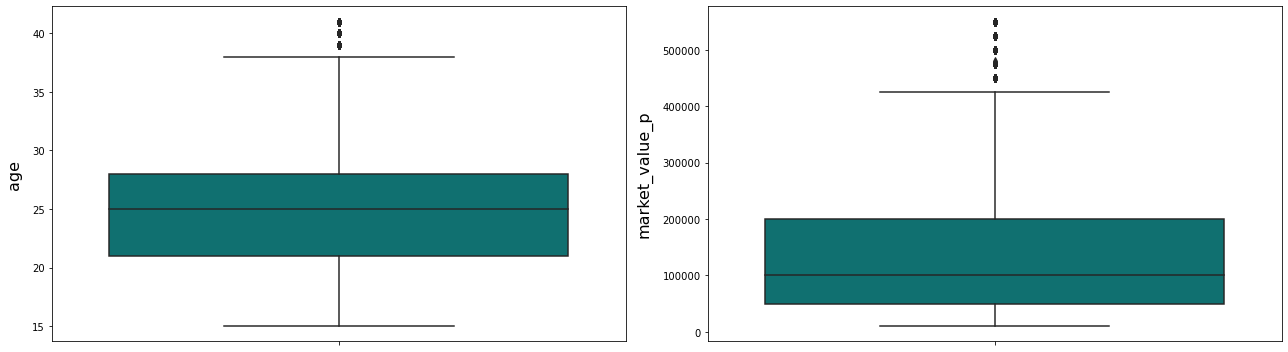

In [272]:
idf = dataset.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.boxplot(y=dataset[cols[index]], color='teal', orient='v')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();


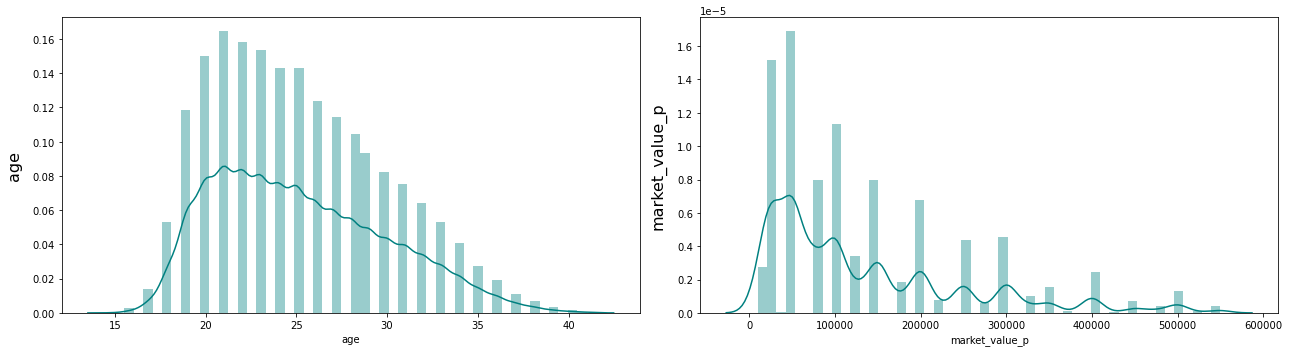

In [273]:
idf = dataset.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.distplot(dataset[cols[index]], color='teal')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();

#### Count Plot For Categorical Features

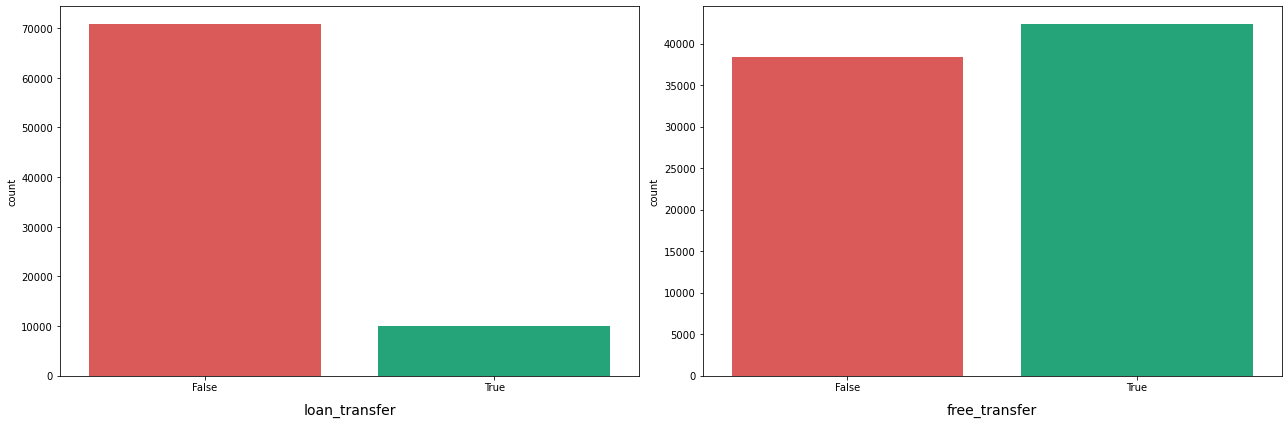

In [274]:
idf = dataset.select_dtypes(include='bool')
cols = idf.columns.tolist()

plt.figure(figsize=(18, 6))
for index in range(0, len(cols)):
    plt.subplot(1, 2, index+1)
    sns.countplot(idf[cols[index]], color='teal', orient='v', palette=binary_pallete)
    plt.tight_layout()
    plt.xlabel(cols[index], fontsize='14', labelpad=10)

plt.show();

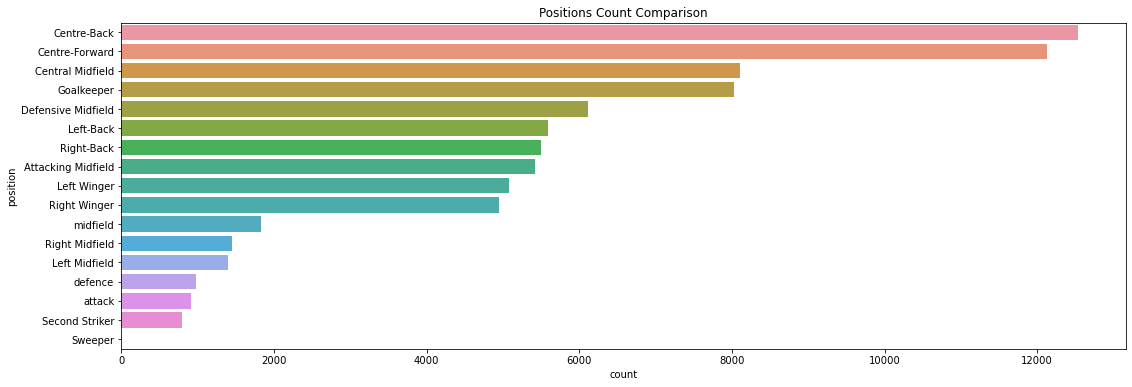

In [275]:
idf = dataset.groupby(['position'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(y='position', x='count', data=idf)
plt.title('Positions Count Comparison')
plt.show();

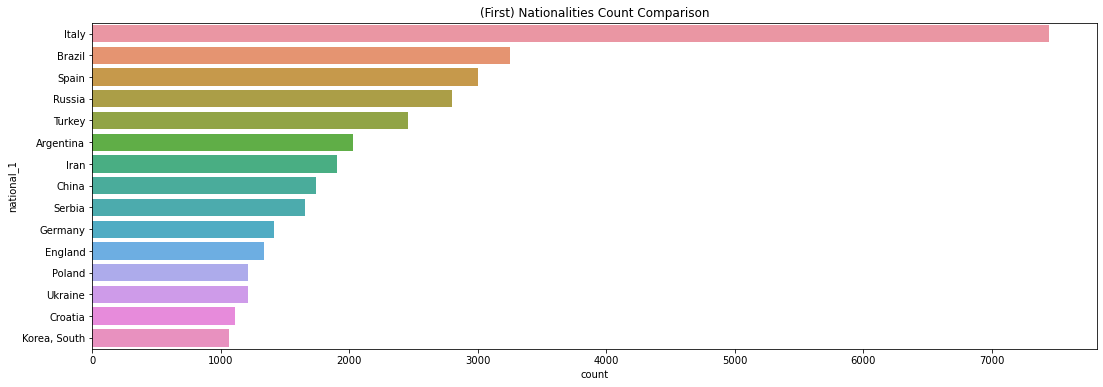

In [276]:
idf = dataset.groupby(['national_1'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(y='national_1', x='count', data=idf[:15])
plt.title('(First) Nationalities Count Comparison')
plt.show();

In [277]:
idf = dataset.groupby(['joined'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(18,8))
sns.barplot(y='joined', x='count', data=idf[:15])
plt.title('Club Arrivals Count Comparison')
plt.show();

KeyError: 'joined'

### Multivariate Analysis

#### Correlation Heatmap

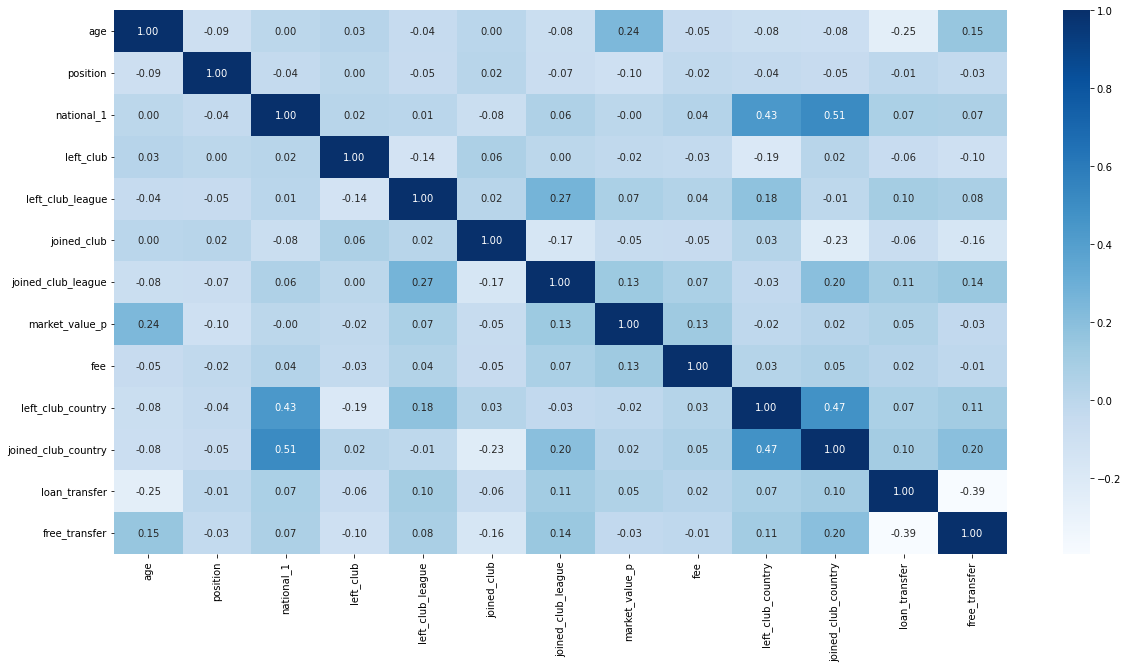

In [ ]:
# label encoding for heatmap
idf = dataset.copy()
for feature in idf.select_dtypes(include='object').columns.tolist():
    idf[feature] = idf[feature].astype('category').cat.codes

plt.figure(figsize=(20, 10))
sns.heatmap(idf.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show();

#### Pairplot

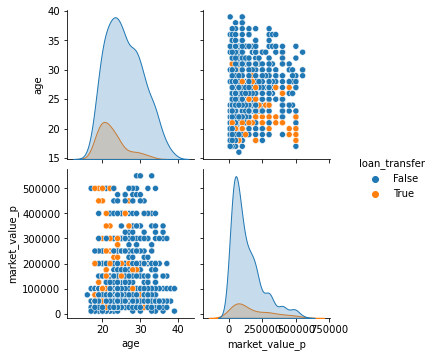

In [ ]:
idf = dataset.select_dtypes(include='number')

cdf = idf.copy()
cdf['loan_transfer'] = dataset['loan_transfer']
sns.pairplot(data=cdf.sample(1000, random_state=1), hue='loan_transfer')

- loan transfer rarely happens on age above 30

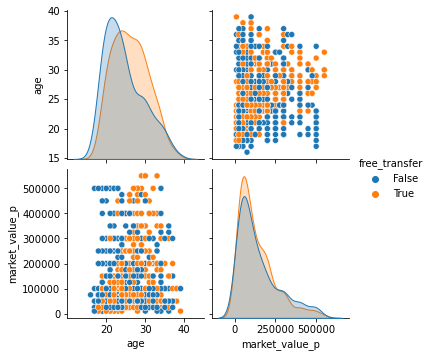

In [ ]:
cdf = idf.copy()
cdf['free_transfer'] = dataset['free_transfer']
sns.pairplot(data=cdf.sample(1000, random_state=1), hue='free_transfer')

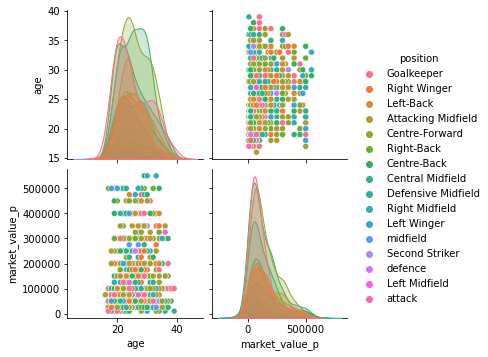

In [ ]:
cdf = idf.copy()
cdf['position'] = dataset['position']
sns.pairplot(data=cdf.sample(1000, random_state=1), hue='position')

### Time Series Analysis

In [ ]:
tdf = dataset.groupby(['transfer_date']).agg(
    transfer_count=pd.NamedAgg(column="age", aggfunc="count")
).reset_index().sort_values(['transfer_date'])

tdf['year'] = tdf['transfer_date'].apply(lambda transfer_date: transfer_date.year)
tdf['month'] = tdf['transfer_date'].apply(lambda transfer_date: transfer_date.month)
tdf['dayofyear'] = tdf['transfer_date'].dt.dayofyear

tdf.sample(5, random_state=1).sort_values('transfer_date')

,transfer_date,transfer_count,year,month,dayofyear
47,2020-08-20,276,2020,8,233
67,2020-09-09,211,2020,9,253
344,2021-06-20,12,2021,6,171
363,2021-07-09,319,2021,7,190
443,2021-09-27,58,2021,9,270


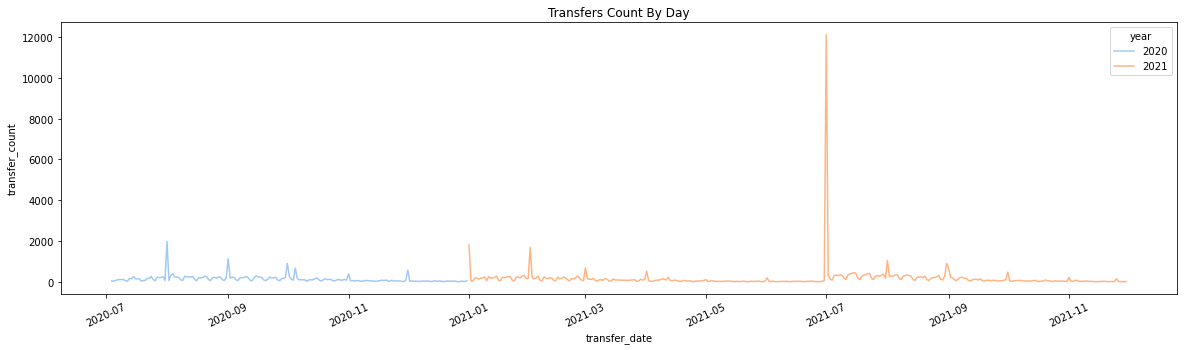

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='transfer_date', y='transfer_count', data=tdf, hue='year', palette='pastel')
plt.xticks(rotation = 25)
plt.title('Transfers Count By Day')
plt.show();

There are big amount of transfers in every first day of months

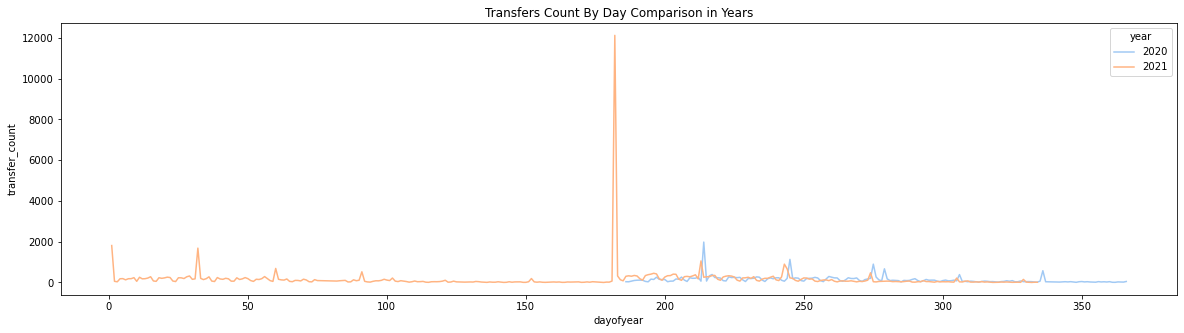

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='dayofyear', y='transfer_count', data=tdf, hue='year', palette='pastel')
plt.title('Transfers Count By Day Comparison in Years')
plt.show();

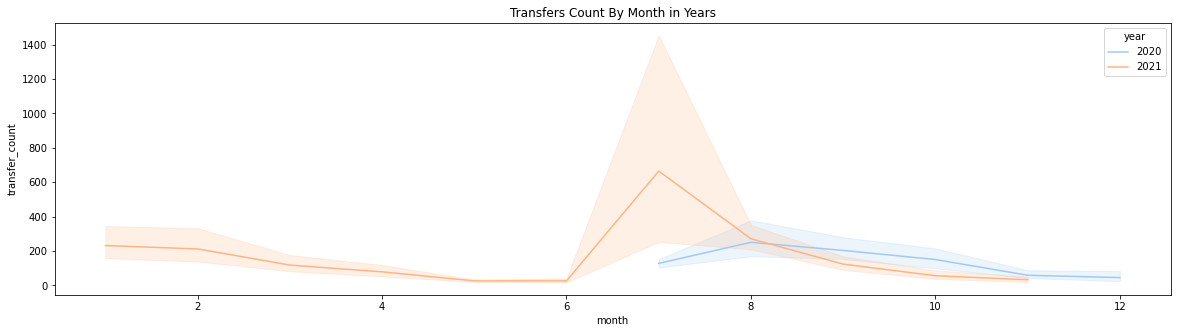

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='month', y='transfer_count', data=tdf, hue='year', palette='pastel')
plt.title('Transfers Count By Month in Years')
plt.show();

### Insights

In [ ]:
pass

## Top UEFA Leagues Analysis

Transfermarkt records all foootball player transfers data around the world and the above analysis also analyzed from data over the world. Mostly people around the world observe and watch football match from the top country leagues, such as Premier league (England), Seria A (Italy) and La Liga (Spain), and so on. So why don't we narrow the data and analyze for top 7 [UEFA country](https://www.uefa.com/nationalassociations/uefarankings/country) and their division one league only?

In [ ]:
uefa = dataset.copy()

# top 10 UEFA coefficient rank countries (2021/22)
top_countries = ['England', 'Italy', 'Spain', 'Germany', 'France', 'Portugal', 'Netherlands']
top_leagues = ['Premier League', 'Serie A', 'LaLiga', 'Bundesliga', 'Ligue 1', 'Liga Bwin', 'Eredivisie']

# filter only for transfer-in by top countries and top leagues
uefa = uefa[uefa['joined_club_country'].isin(top_countries)]
uefa = uefa[uefa['joined_club_league'].isin(top_leagues)]

# handle null value of left_club and joined_club
uefa.dropna(subset=['age', 'left_club', 'joined_club'], inplace=True)
uefa['national_1'].fillna('No Nationality', inplace=True)

# feature selection
uefa = uefa[[
    'age',
    'position',
    'national_1',
    'left_club',
    'left_club_league',
    'left_club_country',
    'joined_club',
    'joined_club_league',
    'joined_club_country',
    'free_transfer',
    'loan_transfer',
    'market_value_p',
    'transfer_date',
]]

# renaming columns
uefa.rename({'market_value_p': 'market_value'}, axis=1, inplace=1)

# casting data types
uefa = uefa.astype({
    "age": int,
    "market_value": int
})

uefa.sample(5, random_state=1)

,age,position,national_1,left_club,left_club_league,left_club_country,joined_club,joined_club_league,joined_club_country,free_transfer,loan_transfer,market_value,transfer_date
75903,21,Right Winger,Portugal,Braga B,NaN,Portugal,Spezia Calcio,Serie A,Italy,False,False,350000,2021-08-30
20918,22,Right-Back,Romania,Villarreal CF B,Seg. Div. B - Fase de ascenso,Spain,ADO Den Haag,Eredivisie,Netherlands,False,True,300000,2020-08-04
21200,21,Centre-Back,New Zealand,Grasshoppers,Challenge League,Switzerland,Rio Ave FC,Liga Bwin,Portugal,False,False,200000,2020-08-29
60148,22,Centre-Forward,No Nationality,AZ Alkmaar U21,Keuken Kampioen Divisie,Netherlands,AZ Alkmaar,Eredivisie,Netherlands,False,False,200000,2021-07-01
6326,20,Left Winger,Italy,Pro Vercelli,Serie C - A,Italy,Crotone,Serie A,Italy,False,False,50000,2020-10-04


In [ ]:
uefa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619 entries, 202 to 88696
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   age                  619 non-null    int32         
 1   position             619 non-null    object        
 2   national_1           619 non-null    object        
 3   left_club            619 non-null    object        
 4   left_club_league     530 non-null    object        
 5   left_club_country    592 non-null    object        
 6   joined_club          619 non-null    object        
 7   joined_club_league   619 non-null    object        
 8   joined_club_country  619 non-null    object        
 9   free_transfer        619 non-null    bool          
 10  loan_transfer        619 non-null    bool          
 11  market_value         619 non-null    int32         
 12  transfer_date        619 non-null    datetime64[ns]
dtypes: bool(2), datetime64[ns](1), 

### Exploratory Data Analysis

#### Univariate Analysis

##### Distribution Plot for Numerical Features

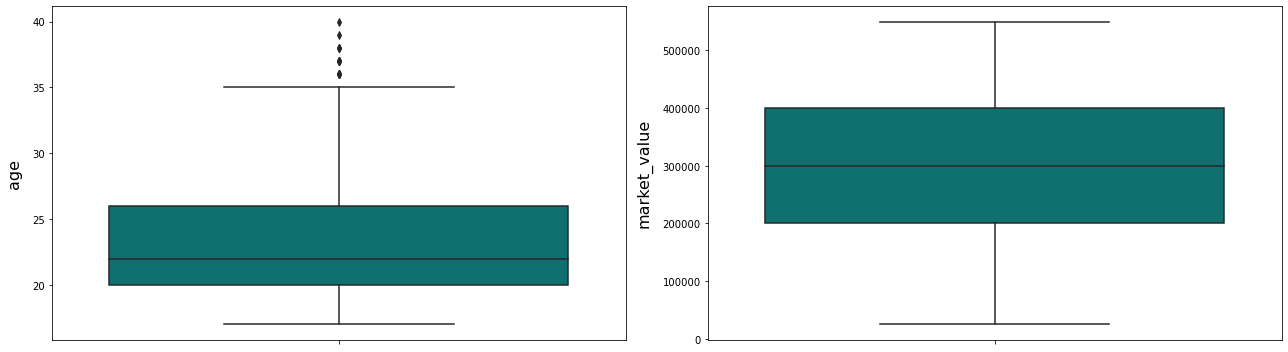

In [ ]:
idf = uefa.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.boxplot(y=uefa[cols[index]], color='teal', orient='v')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();

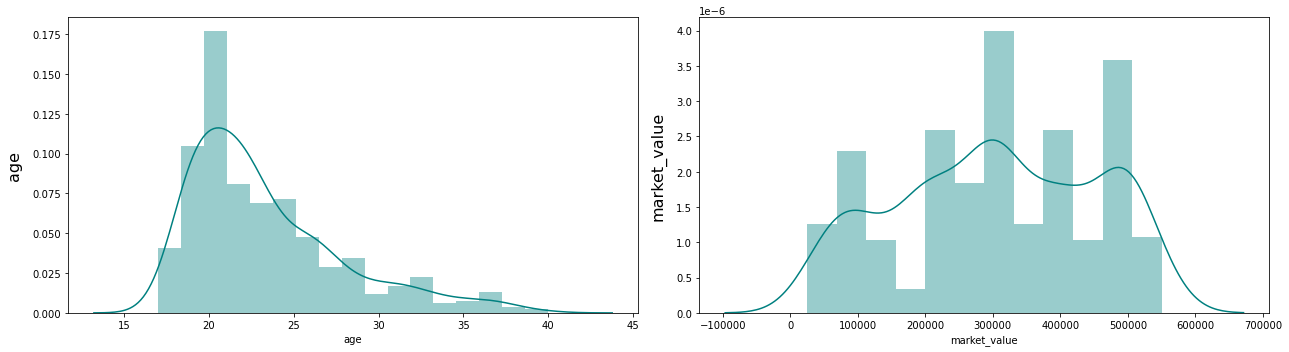

In [ ]:
idf = uefa.select_dtypes(include='number')
cols = idf.columns.to_list()

plt.figure(figsize=(18, 5))
for index in range(0, len(cols)):
    plt.subplot(1, len(cols), index+1)
    sns.distplot(uefa[cols[index]], color='teal')
    plt.ylabel(cols[index], fontsize='16', labelpad=10)
    plt.tight_layout()

plt.show();

##### Count Plot For Categorical Features

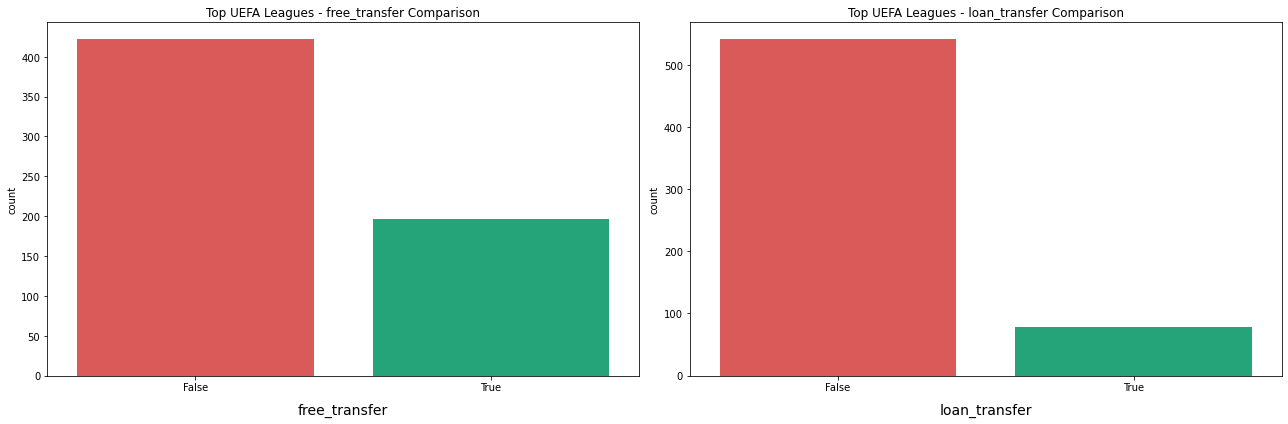

In [ ]:
idf = uefa.select_dtypes(include='bool')
cols = idf.columns.tolist()

plt.figure(figsize=(18, 6))
for index in range(0, len(cols)):
    plt.subplot(1, 2, index+1)
    sns.countplot(idf[cols[index]], color='teal', orient='v', palette=binary_pallete)
    plt.tight_layout()
    plt.xlabel(cols[index], fontsize='14', labelpad=10)
    plt.title(f'Top UEFA Leagues - {cols[index]} Comparison')

plt.show();

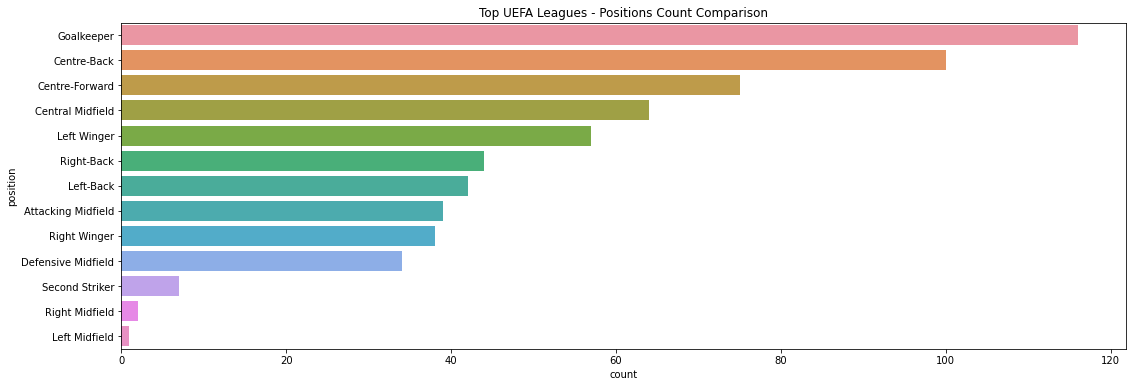

In [ ]:
idf = uefa.groupby(['position'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(y='position', x='count', data=idf)
plt.title('Top UEFA Leagues - Positions Count Comparison')
plt.show();

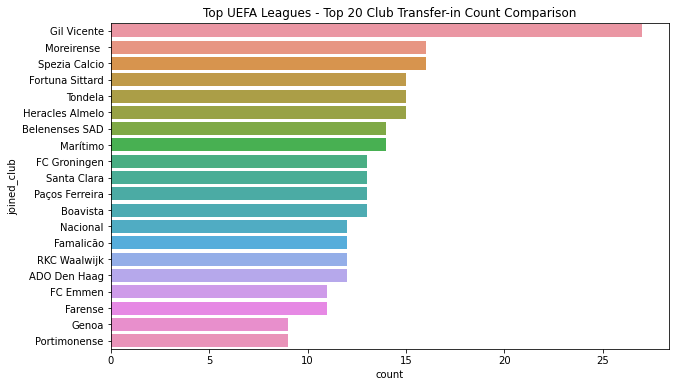

In [ ]:
idf = uefa.groupby(['joined_club'])['age'].describe().reset_index().sort_values(by='count', ascending=False)

top = 20
plt.figure(figsize=(10,6))
sns.barplot(y='joined_club', x='count', data=idf.head(top))
plt.title(f'Top UEFA Leagues - Top {top} Club Transfer-in Count Comparison')
plt.show();

#### Multivariate Analysis

##### Correlation Heatmap

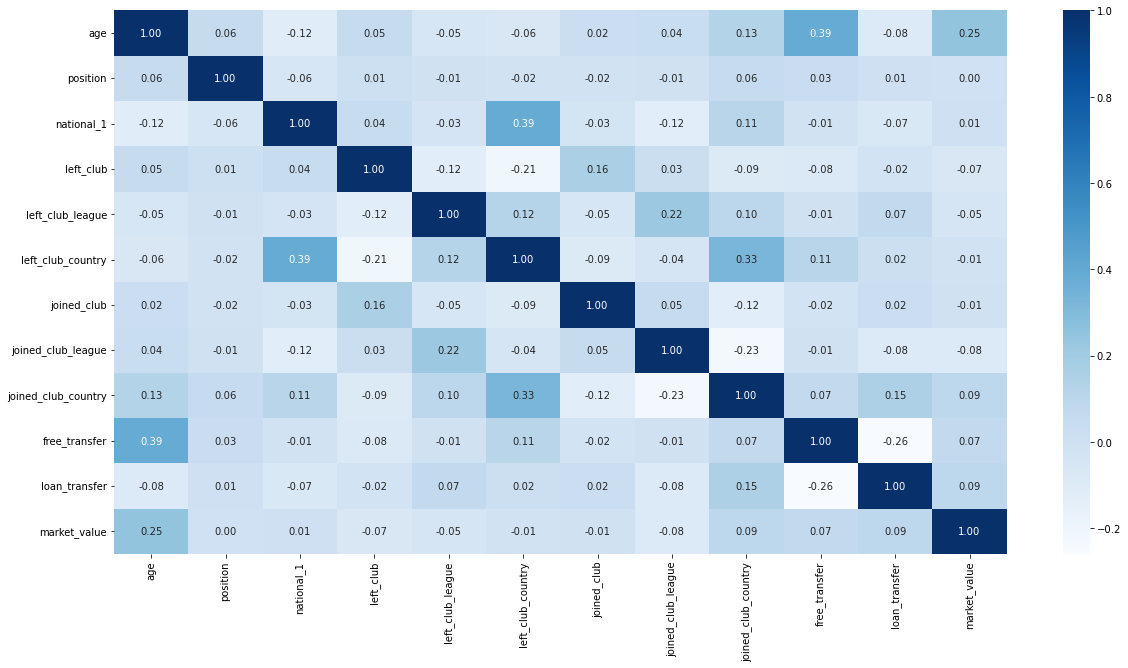

In [ ]:
# label encoding for heatmap
idf = uefa.copy()
for feature in idf.select_dtypes(include='object').columns.tolist():
    idf[feature] = idf[feature].astype('category').cat.codes

plt.figure(figsize=(20, 10))
sns.heatmap(idf.corr(), cmap='Blues', annot=True, fmt='.2f')
plt.show();

##### Pairplot

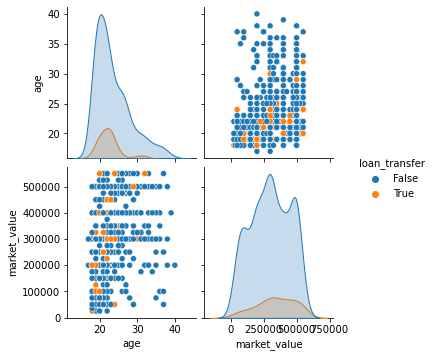

In [282]:
idf = uefa.select_dtypes(include='number')

cdf = idf.copy()
cdf['loan_transfer'] = uefa['loan_transfer']
sns.pairplot(data=cdf, hue='loan_transfer')
plt.show();

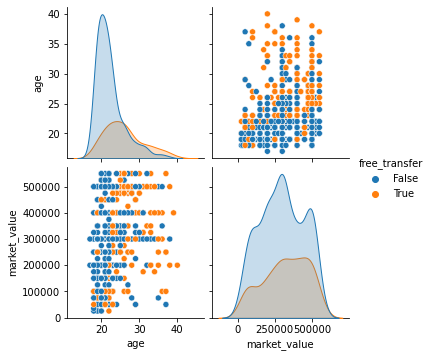

In [283]:
cdf = idf.copy()
cdf['free_transfer'] = dataset['free_transfer']
sns.pairplot(data=cdf, hue='free_transfer')
plt.show();

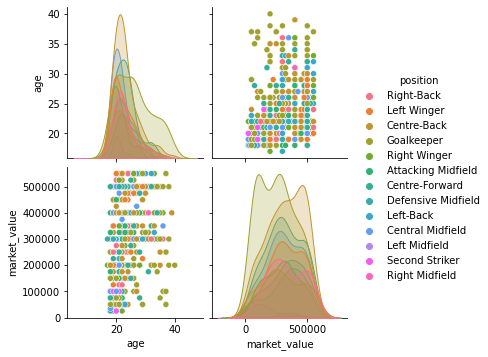

In [286]:
cdf = idf.copy()
cdf['position'] = uefa['position']
sns.pairplot(data=cdf, hue='position')
plt.show();

### Time Series Analysis

In [ ]:
tdf = uefa.groupby(['transfer_date']).agg(
    transfer_count=pd.NamedAgg(column="age", aggfunc="count")
).reset_index().sort_values(['transfer_date'])

tdf['year'] = tdf['transfer_date'].apply(lambda transfer_date: transfer_date.year)
tdf['month'] = tdf['transfer_date'].apply(lambda transfer_date: transfer_date.month)
tdf['dayofyear'] = tdf['transfer_date'].dt.dayofyear

tdf.sample(5, random_state=1).sort_values('transfer_date')

,transfer_date,transfer_count,year,month,dayofyear
4,2020-07-13,2,2020,7,195
40,2020-09-01,20,2020,9,245
116,2021-07-04,2,2021,7,185
132,2021-07-24,1,2021,7,205
148,2021-08-16,1,2021,8,228


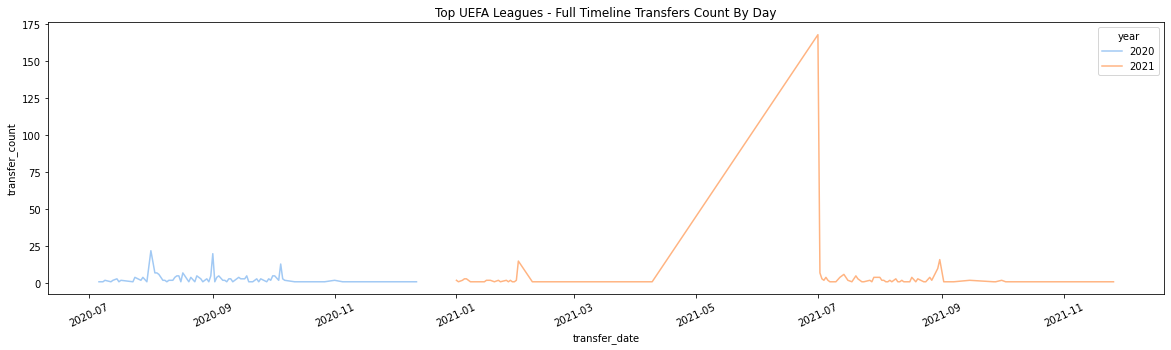

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='transfer_date', y='transfer_count', data=tdf, hue='year', palette='pastel')
plt.xticks(rotation = 25)
plt.title('Top UEFA Leagues - Full Timeline Transfers Count By Day')
plt.show();

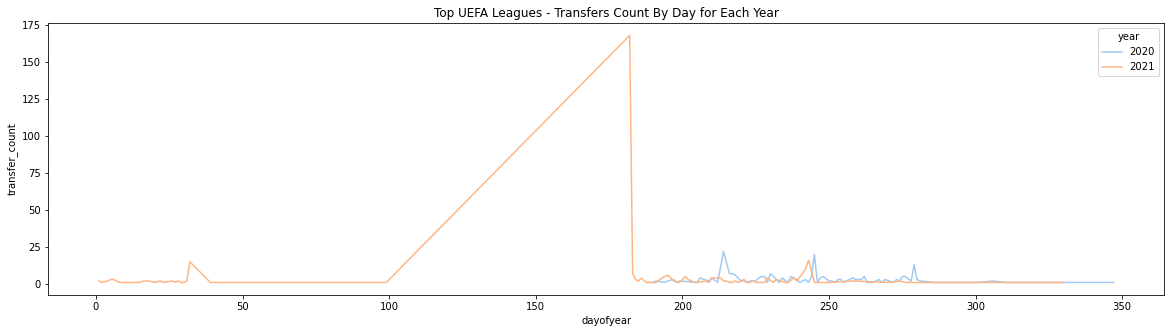

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(x='dayofyear', y='transfer_count', data=tdf, hue='year', palette='pastel')
plt.title('Top UEFA Leagues - Transfers Count By Day for Each Year')
plt.show();